In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from distutils.dir_util import copy_tree, remove_tree
from random import randint
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow_addons as tfa
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
import cv2
import keras

In [3]:
base='./data2/'
# root_dir='./'
test=base+"test/"
train=base+"train/"
wdr="./dataset2/"
if os.path.exists(wdr):
    remove_tree(wdr)
os.mkdir(wdr)
copy_tree(train,wdr)
copy_tree(test,wdr)
print("wdc:",os.listdir(wdr))

wdc: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [4]:
work='./dataset2/'
classes=['glioma', 'meningioma', 'notumor', 'pituitary']
idm=176
ida=[176,208]
DIM=(idm,idm)

In [5]:
train_data_gen=IDG(rescale=1./255)
# train_data_gen=train_data_gen.flow_from_directory(directory=work,target_size=DIM,batch_size=6500)
train_data_gen = train_data_gen.flow_from_directory(directory=work, target_size=DIM, batch_size=6500 * 24) #12 for more good res

Found 10183 images belonging to 4 classes.


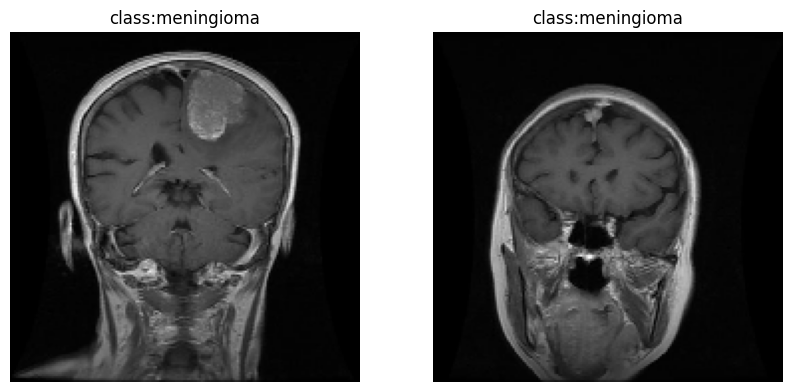

In [6]:
def show_images(generator):
    labels=dict(zip([0,1,2,3],classes))
    x,y=generator.next()
    plt.figure(figsize=(10,10))
    for i in range(2):
        ax=plt.subplot(2,2,i+1)
        idx=randint(0,300)
        plt.imshow(x[idx])
        plt.axis("off")
        plt.title("class:{}".format(labels[np.argmax(y[idx])]))

show_images(train_data_gen)

In [7]:
train_data,train_labels=train_data_gen.next()

In [8]:
sm=SMOTE(random_state=42)
train_data,train_labels=sm.fit_resample(train_data.reshape(-1,idm*idm*3),train_labels)
train_data=train_data.reshape(-1,idm,idm,3)
print(train_data.shape,train_labels.shape)

(10632, 176, 176, 3) (10632, 4)


In [9]:
train_data,test_data,train_labels,test_labels=train_test_split(train_data,train_labels,test_size=0.2,random_state=42)
train_data,val_data,train_labels,val_labels=train_test_split(train_data,train_labels,test_size=0.2,random_state=42)

In [10]:
incmodel=keras.models.load_model('./BT_CNN_model4')
incmodel.summary()

Model: "inception_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 4, 4, 1536)       54336736  
 onal)                                                           
                                                                 
 dropout_15 (Dropout)        (None, 4, 4, 1536)        0         
                                                                 
 global_average_pooling2d_3   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_3 (Flatten)         (None, 1536)              0         
                                                                 
 batch_normalization_827 (Ba  (None, 1536)             6144      
 tchNormalization)                                               
                                               

In [11]:
METRICS=[tf.keras.metrics.CategoricalAccuracy(name='train_acc'),
         tf.keras.metrics.AUC(name='val_acc'),
         tfa.metrics.F1Score(num_classes=4)]
incmodel.compile(loss=tf.losses.CategoricalCrossentropy(),metrics=METRICS)
incmodel.summary()

Model: "inception_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 inception_resnet_v2 (Functi  (None, 4, 4, 1536)       54336736  
 onal)                                                           
                                                                 
 dropout_15 (Dropout)        (None, 4, 4, 1536)        0         
                                                                 
 global_average_pooling2d_3   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_3 (Flatten)         (None, 1536)              0         
                                                                 
 batch_normalization_827 (Ba  (None, 1536)             6144      
 tchNormalization)                                               
                                                                 
 dense_15 (Dense)            (None, 512)               786944    
                                                                 
 batch_nor

In [12]:
EPOCHS=10
history=incmodel.fit(train_data,train_labels,validation_data=(val_data,val_labels),epochs=EPOCHS)

Epoch 1/10
213/213 [==============================] - 230s 1s/step - loss: 0.1393 - train_acc: 0.9588 - val_acc: 0.9945 - f1_score: 0.9588 - val_loss: 0.0790 - val_train_acc: 0.9782 - val_val_acc: 0.9975 - val_f1_score: 0.9780
Epoch 2/10
213/213 [==============================] - 233s 1s/step - loss: 0.1025 - train_acc: 0.9684 - val_acc: 0.9964 - f1_score: 0.9684 - val_loss: 0.1115 - val_train_acc: 0.9647 - val_val_acc: 0.9969 - val_f1_score: 0.9646
Epoch 3/10
213/213 [==============================] - 233s 1s/step - loss: 0.0771 - train_acc: 0.9752 - val_acc: 0.9983 - f1_score: 0.9752 - val_loss: 0.0795 - val_train_acc: 0.9735 - val_val_acc: 0.9976 - val_f1_score: 0.9734
Epoch 4/10
213/213 [==============================] - 229s 1s/step - loss: 0.0692 - train_acc: 0.9778 - val_acc: 0.9984 - f1_score: 0.9778 - val_loss: 0.0875 - val_train_acc: 0.9747 - val_val_acc: 0.9978 - val_f1_score: 0.9744
Epoch 5/10
213/213 [==============================] - 236s 1s/step - loss: 0.0703 - train_ac

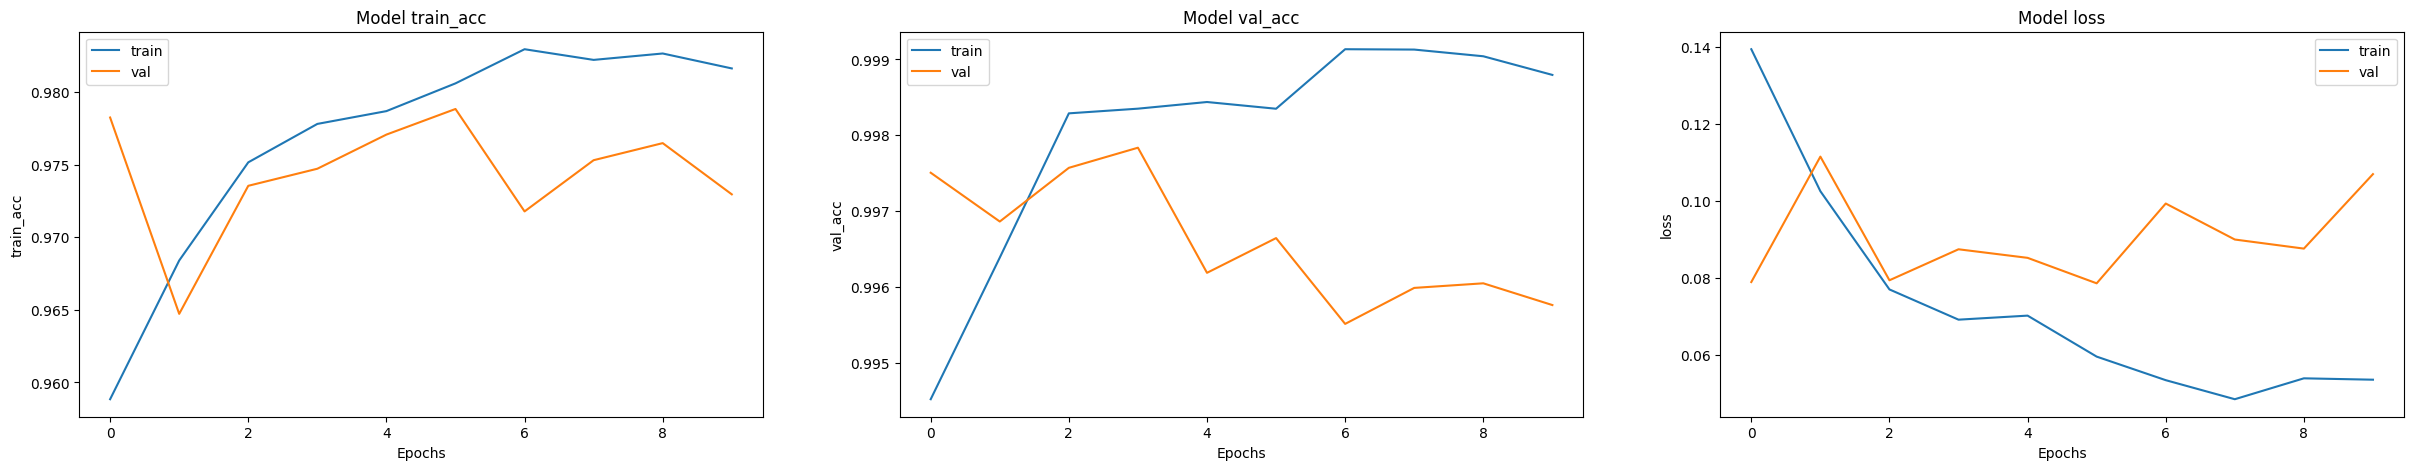

In [13]:
fig ,ax=plt.subplots(1,3,figsize=(30,5))
ax=ax.ravel()
for i,metric in enumerate(["train_acc","val_acc","loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_"+metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train","val"])

In [14]:
test_scores=incmodel.evaluate(test_data,test_labels)
print("Loss: ", test_scores[0])
print("Accuracy: ", test_scores[1])

67/67 [==============================] - 60s 899ms/step - loss: 0.1031 - train_acc: 0.9751 - val_acc: 0.9962 - f1_score: 0.9752
Loss:  0.10311656445264816
Accuracy:  0.975082278251648


In [15]:
pred_labels=incmodel.predict(test_data)

67/67 [==============================] - 59s 859ms/step


In [16]:
def roundoff(arr):
    arr[np.argwhere(arr!=arr.max())]=0
    arr[np.argwhere(arr==arr.max())]=1
    return arr
for labels in pred_labels:
    labels=roundoff(labels)
print(classification_report(test_labels,pred_labels,target_names=classes))

              precision    recall  f1-score   support

      glioma       0.99      0.94      0.97       578
  meningioma       0.93      0.98      0.95       505
     notumor       1.00      0.99      1.00       519
   pituitary       0.98      0.99      0.99       525

   micro avg       0.98      0.98      0.98      2127
   macro avg       0.98      0.98      0.98      2127
weighted avg       0.98      0.98      0.98      2127
 samples avg       0.98      0.98      0.98      2127



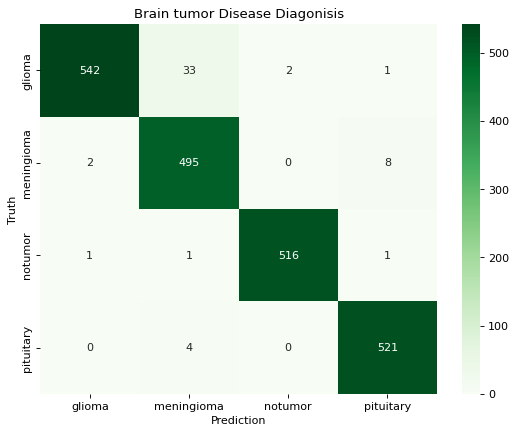

In [17]:
pred_ls=np.argmax(pred_labels,axis=1)
test_ls=np.argmax(test_labels,axis=1)
conf_arr=confusion_matrix(test_ls,pred_ls)
plt.figure(figsize=(8,6),dpi=80,facecolor='w',edgecolor='k')
ax=sns.heatmap(conf_arr,cmap='Greens',annot=True,fmt='d',xticklabels=classes,yticklabels=classes)
plt.title('Brain tumor Disease Diagonisis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

In [18]:
print('Balanced Accuracy score {}%'.format(round(BAS(test_ls,pred_ls)*100,2)))
print('Matthews Correleation Corrcoef {}%'.format(round(MCC(test_ls,pred_ls)*100,2)))

Balanced Accuracy score 97.61%
Matthews Correleation Corrcoef 96.7%


In [19]:
custom_incmodel_dir=wdr+"BT_CNN_model7"
incmodel.save(custom_incmodel_dir,save_format='h5')
os.listdir(wdr)

['BT_CNN_model7', 'glioma', 'meningioma', 'notumor', 'pituitary']

In [21]:
ci=['glioma','meningioma','no-tumor','pituitary']
# Load the image
image = cv2.imread('./img.jpg')

# Resize the image to match the expected input shape
image = cv2.resize(image, (176, 176))

# Normalize the image
image = image / 255.0

# Add an extra dimension to the image
image = np.expand_dims(image, axis=0)

# Load the model
model = keras.models.load_model('./BT_CNN_model7')

# Predict the class probabilities of the image
prediction = model.predict(image)

# Get the index of the class with the highest probability
pci = np.argmax(prediction[0])

# Display the result
print(prediction[0])
print('The predicted class is:', ci[pci])


1/1 [==============================] - 2s 2s/step
[0.55807483 0.30633357 0.13421316 0.00137838]
The predicted class is: glioma


In [ ]:
# import cv2
# import numpy as np

# # Load the image using cv2
# image = cv2.imread('Te-pi_0116.jpg')

# # Convert the image to a matrix array
# image_array = np.array(image)

# # Save the array to a file
# np.save('image_array.npy', image_array)


In [ ]:
# import sqlite3
# from sqlite3 import Error
# from PIL import Image
# from io import BytesIO
# import os

# # Function to convert image to bytes
# def image_to_bytes(image):
#     with BytesIO() as byte_stream:
#         image.save(byte_stream, format='PNG')
#         byte_stream.seek(0)
#         return byte_stream.read()

# # Function to convert bytes to image
# def bytes_to_image(byte_data):
#     return Image.open(BytesIO(byte_data))

# # Save image to SQLite database
# def save_image_to_db(user_id, image_path, db_path):
#     try:
#         # Read image file
#         with open(image_path, 'rb') as image_file:
#             image_data = image_file.read()

#         # Connect to SQLite database
#         conn = sqlite3.connect(db_path)
#         cursor = conn.cursor()

#         # Create table if it doesn't exist
#         cursor.execute('''CREATE TABLE IF NOT EXISTS images
#                           (id INTEGER PRIMARY KEY AUTOINCREMENT, user_id INTEGER, data BLOB)''')

#         # Check the count of images already saved by the user
#         cursor.execute('SELECT COUNT(*) FROM images WHERE user_id = ?', (user_id,))
#         count = cursor.fetchone()[0]
#         if count >= 3:
#             print('The user has already saved three images.')
#             conn.close()
#             return

#         # Insert image data into the table
#         cursor.execute('INSERT INTO images (user_id, data) VALUES (?, ?)', (user_id, image_data))
#         conn.commit()

#         # Close the connection
#         conn.close()
#         print('Image saved successfully!')
#     except Error as e:
#         print(f'Error saving image to database: {e}')

# # Fetch images for a user from SQLite database
# def fetch_images_from_db(user_id, db_path, save_folder):
#     try:
#         # Connect to SQLite database
#         conn = sqlite3.connect(db_path)
#         cursor = conn.cursor()

#         # Create table if it doesn't exist
#         cursor.execute('''CREATE TABLE IF NOT EXISTS images
#                           (id INTEGER PRIMARY KEY AUTOINCREMENT, user_id INTEGER, data BLOB)''')

#         # Fetch image data from the table
#         cursor.execute('SELECT data FROM images WHERE user_id = ?', (user_id,))
#         image_data_list = cursor.fetchall()

#         # Create the save folder if it doesn't exist
#         os.makedirs(save_folder, exist_ok=True)

#         # Save fetched images to the folder
#         for i, image_data in enumerate(image_data_list):
#             # Convert bytes to image
#             image = bytes_to_image(image_data[0])

#             # Create the filename based on user ID and sequence number
#             filename = f'{user_id}_save{i}.png'
#             save_path = os.path.join(save_folder, filename)

#             # Save image to file
#             image.save(save_path)

#         # Close the connection
#         conn.close()
#         print('Images fetched successfully!')
#     except Error as e:
#         print(f'Error fetching images from database: {e}')

# user_id = 1
# image_path = './img.jpg'
# db_path = './database.db'
# save_folder = './simg/'


In [ ]:
# Save image to database
save_image_to_db(user_id, image_path, db_path)

Image saved successfully!


In [ ]:
# Fetch images from database for the user
fetch_images_from_db(user_id, db_path, save_folder)

Images fetched successfully!
